In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.metrics import accuracy_score, auc, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.svm import SVC
from time import time

In [2]:
df = pd.read_csv('model_dataset.csv',usecols=['ID','job_description_text','seniority_level'])
df

,ID,job_description_text,seniority_level
0,1,Company DescriptionThe Ikigai platform unlocks...,Mid-Senior level
1,4,Job Title: Machine Learning EngineerLocation: ...,Mid-Senior level
2,21,About UsNational Grid is hiring a Senior Data ...,Mid-Senior level
3,22,About UsNational Grid is hiring a Senior Data ...,Mid-Senior level
4,23,About UsNational Grid is hiring a Senior Data ...,Mid-Senior level
...,...,...,...
736,965,What is Aviture?Aviture is a full-service tech...,Junior level
737,976,Location: US RemoteJob SummaryWe are seeking a...,Junior level
738,980,ResponsibilitiesThe Business Risk Integrated C...,Junior level
739,981,Location: US RemoteJob SummaryWe are seeking a...,Junior level


In [3]:
%%markdown
# TF-IDF Vectorization
The first step before applying TF-IDF vectorization is to choose some of its important settings such as `min_df` and `max_df`. 
Respectively these parameters stand for the minimum and the maximum number of vacancies a term can appear in.<br>
To help determine these settings I make plots of components of principal component analysis on the output of 12 iterations of sklearn's `TfidfVectorizer`:
`min_df` ranged from 4 to 7 and `max_df` was set at 40, 50 or 60.<br>
Ultimately, the plots do not differ much from one another. Therefore I'm choosing the settings `min_df = 4` and `max_df = 40` for `TfidfVectorizer`. 
Additionally, I set `ngram_range` at `(1,2)`. This means the vectorizer includes unigrams (one word) and bigrams (two words). 

# TF-IDF Vectorization
The first step before applying TF-IDF vectorization is to choose some of its important settings such as `min_df` and `max_df`. 
Respectively these parameters stand for the minimum and the maximum number of vacancies a term can appear in.<br>
To help determine these settings I make plots of components of principal component analysis on the output of 12 iterations of sklearn's `TfidfVectorizer`:
`min_df` ranged from 4 to 7 and `max_df` was set at 40, 50 or 60.<br>
Ultimately, the plots do not differ much from one another. Therefore I'm choosing the settings `min_df = 4` and `max_df = 40` for `TfidfVectorizer`. 
Additionally, I set `ngram_range` at `(1,2)`. This means the vectorizer includes unigrams (one word) and bigrams (two words). 


In [4]:
# function to perform PCA on output of TfidfVectorizer
def to_be_named(min_df, max_df):
    
    vectorizer = TfidfVectorizer(stop_words = 'english', sublinear_tf = True, ngram_range = (1,2), norm = 'l2', min_df = min_df, max_df = max_df)
    features = vectorizer.fit_transform(df.job_description_text).toarray()

    print("dimensions are {}".format(np.shape(features)))

    pca = PCA(n_components=2)
    pca_fitted = pca.fit(features.T)

    pca_df = pd.DataFrame(pca_fitted.components_.T, columns=['comp1', 'comp2'])
    plot_set = pd.merge(df, pca_df, left_index = True, right_index = True)
    
    ax_I = sns.scatterplot(data=plot_set, x="comp1", y="comp2", hue="seniority_level")
    ax_I.set(title = 'Component plot, min_df is {}, max_df is {}'.format(i,j))
    plt.show()
    
    vectorizer 

dimensions are (741, 16998)


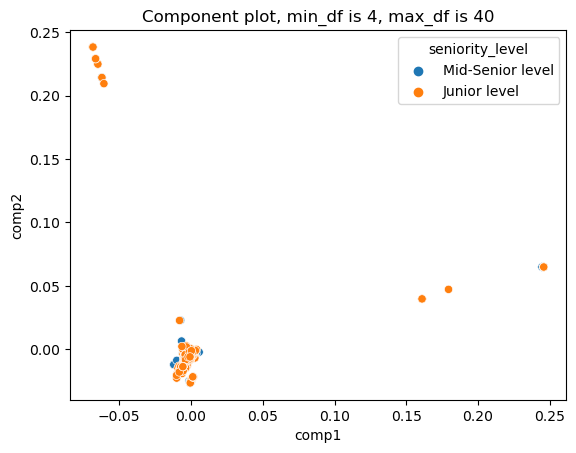

dimensions are (741, 17246)


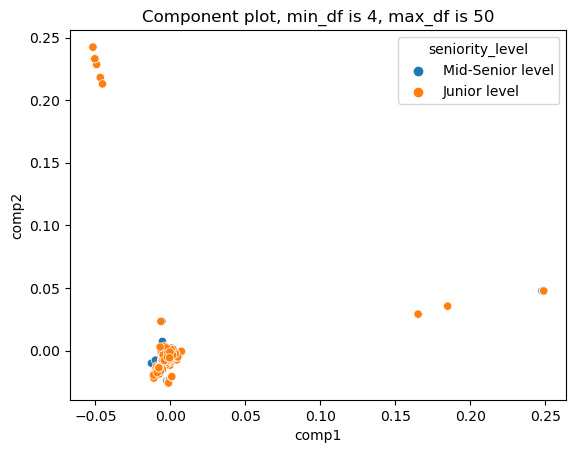

dimensions are (741, 17422)


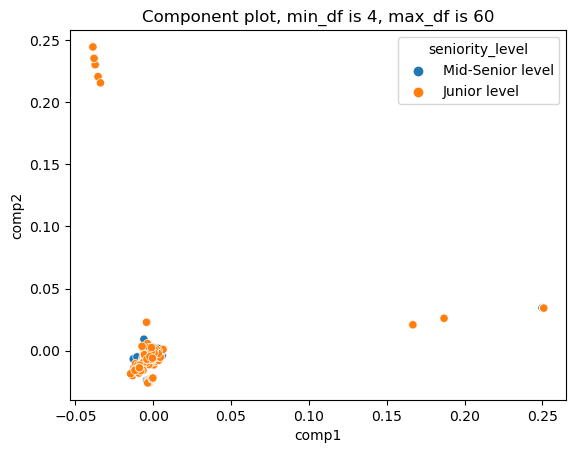

dimensions are (741, 12743)


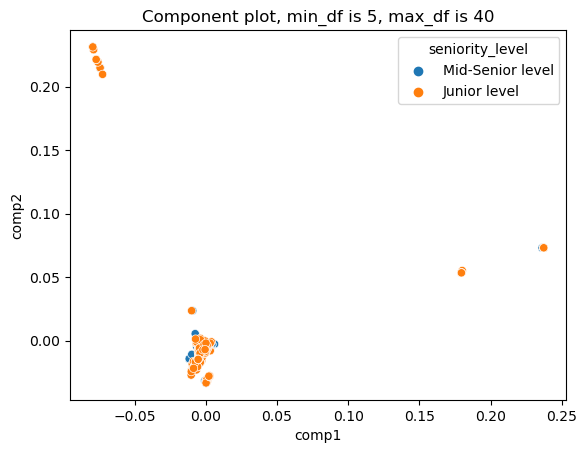

dimensions are (741, 12991)


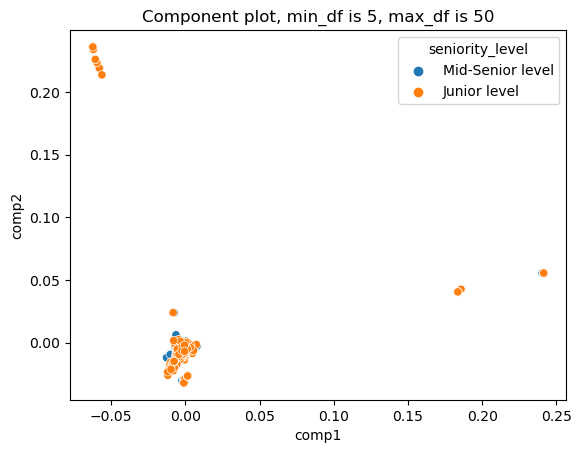

dimensions are (741, 13167)


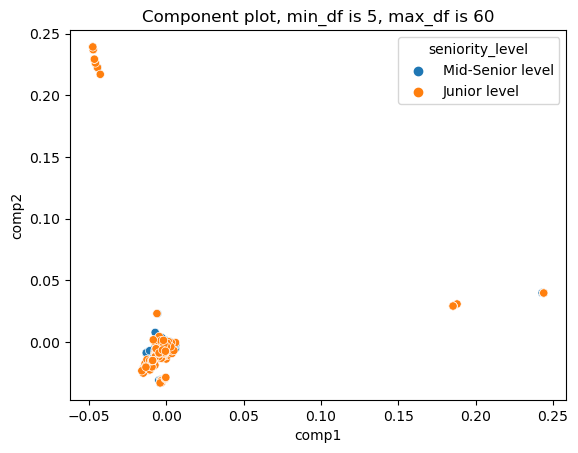

dimensions are (741, 9428)


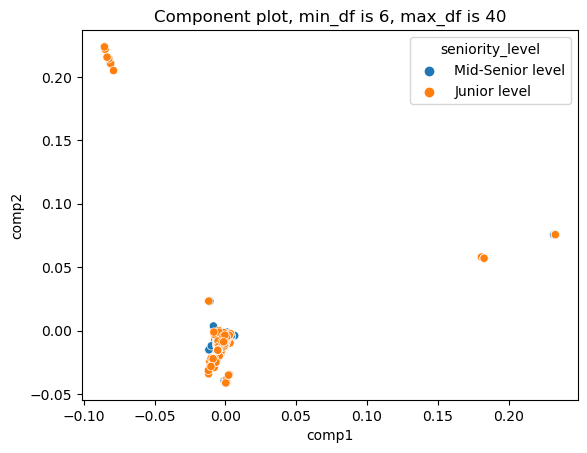

dimensions are (741, 9676)


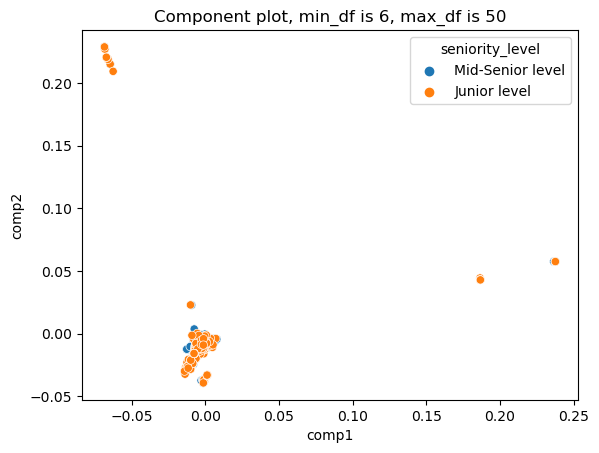

dimensions are (741, 9852)


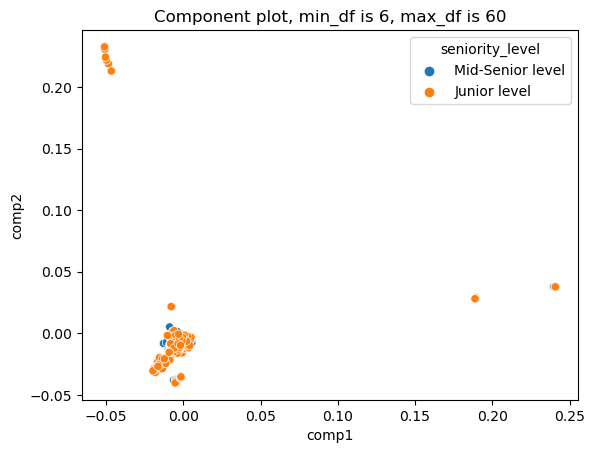

dimensions are (741, 7930)


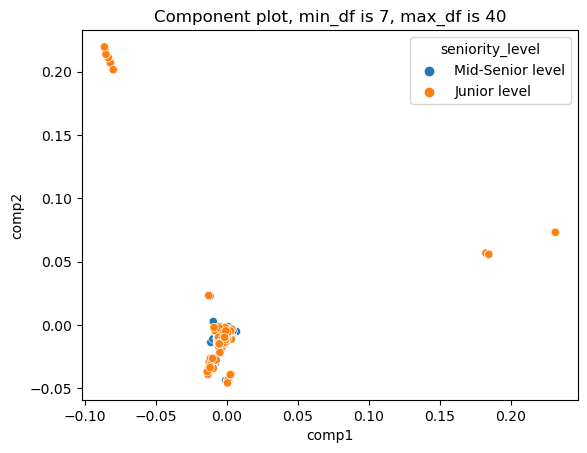

dimensions are (741, 8178)


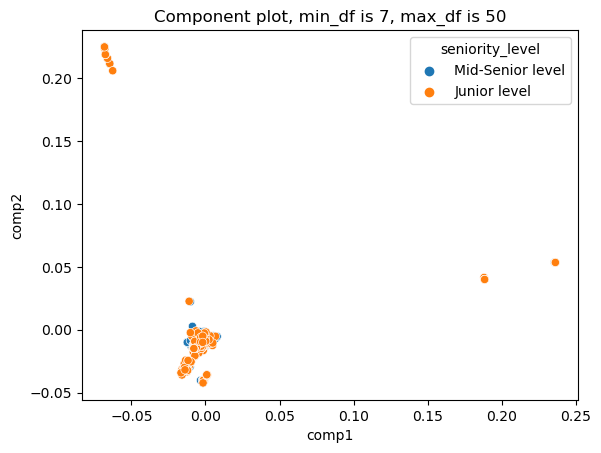

dimensions are (741, 8354)


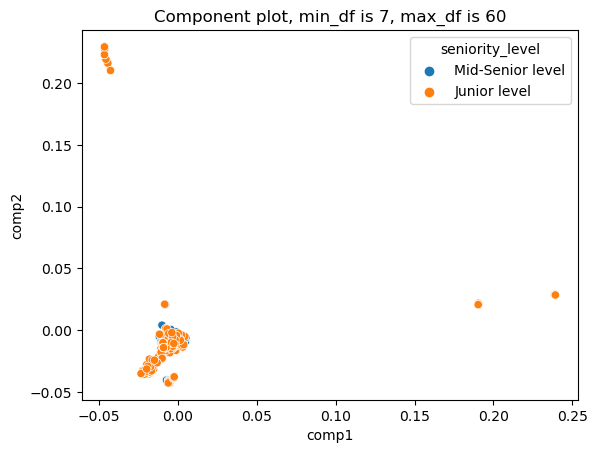

In [5]:
min_df_list = [4,5,6,7]
max_df_list = [40,50,60]

for i in min_df_list:
    for j in max_df_list:
        to_be_named(i,j)        

In [6]:
# Fitting and transforming the vacancy texts with TF-IDF vectorizer 
vectorizer = TfidfVectorizer(stop_words = 'english', sublinear_tf = True, ngram_range = (1,2), norm = 'l2', min_df = 4, max_df = 40)
features = vectorizer.fit_transform(df.job_description_text).toarray()

# Splitting 'features' and the dependent variable (df.seniority_level) into a train and test set
X_train, X_test, y_train, y_test = train_test_split(
    features, df.seniority_level, train_size=500, random_state=862025)

In [7]:
%%markdown
# Singular Value Decomposition
To decrease the number of features I use the Singular Value Decomposition (SVD) method. Of course, one of the first decisions to make is to determine the number of components. 
To make an informed decision I train and fit SVDs with a varying number of components.<br> For evaluation purposes I track the explained variance and the time it takes to train the SVD.   

# Singular Value Decomposition
To decrease the number of features I use the Singular Value Decomposition (SVD) method. Of course, one of the first decisions to make is to determine the number of components. 
To make an informed decision I train and fit SVDs with a varying number of components.<br> For evaluation purposes I track the explained variance and the time it takes to train the SVD.   


In [6]:
# For loop to look at explained variance and performance of computed components
components_SVD = [50, 60, 70, 80, 90, 100]
variance_ratio_list = []

for component in components_SVD:
    begin_hier = time()
    svd = TruncatedSVD(n_components = component, algorithm = 'arpack')    
    features_reduced = svd.fit_transform(X_train)
    end_hier = time()
    tijd = end_hier - begin_hier

    variance_ratio_list.append([component, svd.explained_variance_ratio_.sum(), tijd])

SVD_Results = pd.DataFrame(variance_ratio_list, columns=['Components', 'ExplainedVar', 'Time (sec)'])
SVD_Results

,Components,ExplainedVar,Time (sec)
0,50,0.335861,58.311476
1,60,0.376175,65.389603
2,70,0.413582,60.920790
3,80,0.445571,74.786166
4,90,0.474287,86.706077
5,100,0.501188,103.384861


In [8]:
%%markdown
I think the trained SVD with 70 components strikes a effective balance between a relatively high explained variance and efficiency in terms of timing. 
Thus, that will be the first SVD which I will use to predict whether a vacancy is for a junior level or a mid-senior level position.

I think the trained SVD with 70 components strikes a effective balance between a relatively high explained variance and efficiency in terms of timing. 
Thus, that will be the first SVD which I will use to predict whether a vacancy is for a junior level or a mid-senior level position.


In [9]:
# The final SVD with 70 components
svd = TruncatedSVD(n_components = 70, algorithm = 'arpack')
X_train_svd = svd.fit_transform(X_train)

In [10]:
%%markdown
# Iteration 1
### Model training and evaluation 
To predict the right type of vacancy, I will train and test two models: A logistic regression and a support vector machine (SVM). 
Both of these models are relatively fast. Also, the logistic regression is a relatively simple model while the SVM is complex but powerful. 
It will be interesting to see whether the results reflect this. 
The training steps for both models are:
    
* Perform a grid search to find the best C parameter. 
* Do a cross validation on the best estimator of the training data. 
    * Evaluate the cross validation on accuracy and the Area Under Curve (AUC) score.

AUC is the probability that a model correctly classifies an observation. Compared with accuracy it is more about how much randomness is involved in predicting the right category.
This makes it in my opinion an useful addition to assess the trained models.

# Iteration 1
### Model training and evaluation 
To predict the right type of vacancy, I will train and test two models: A logistic regression and a support vector machine (SVM). 
Both of these models are relatively fast. Also, the logistic regression is a relatively simple model while the SVM is complex but powerful. 
It will be interesting to see whether the results reflect this. 
The training steps for both models are:
    
* Perform a grid search to find the best C parameter. 
* Do a cross validation on the best estimator of the training data. 
    * Evaluate the cross validation on accuracy and the Area Under Curve (AUC) score.

AUC is the probability that a model correctly classifies an observation. Compared with accuracy it is more about how much randomness is involved in predicting the right category.
This makes it in my opinion an useful addition to assess the trained models.


In [11]:
# Grid search on logistic regression 
C_grid = np.linspace(0.01,5,10)
parameters = {'C': C_grid}

Logit_grid = LogisticRegression()
Log_gs_cv = GridSearchCV(Logit_grid, parameters).fit(X_train_svd, y_train)

cv_log_model = cross_validate(Log_gs_cv.best_estimator_, X_train_svd, y_train, 
                              cv = 3, scoring = ('accuracy', 'roc_auc'))

cv_log_model

{'fit_time': array([0.39290977, 0.19517589, 0.40027714]),
 'score_time': array([0.00566077, 0.09815025, 0.09960389]),
 'test_accuracy': array([0.67664671, 0.61676647, 0.6686747 ]),
 'test_roc_auc': array([0.76491681, 0.67355135, 0.71490782])}

In [8]:
Log_gs_cv.best_estimator_

LogisticRegression(C=4.445555555555556)

In [12]:
# Grid search on support vector machine
C_grid = np.linspace(0.01,5,10)
kernel_grid = ['rbf', 'linear'] 
parameters = {'C': C_grid, 'kernel': kernel_grid}

SVM_grid = SVC(probability= True)
Svm_gs_cv = GridSearchCV(SVM_grid, parameters).fit(X_train_svd, y_train)

cv_svm_model = cross_validate(Svm_gs_cv.best_estimator_, X_train_svd, y_train, 
                              cv = 3, scoring = ('accuracy', 'roc_auc'))

cv_svm_model

{'fit_time': array([0.18936706, 0.10775089, 0.10420275]),
 'score_time': array([0.01024508, 0.08715367, 0.00968122]),
 'test_accuracy': array([0.7005988 , 0.59281437, 0.6686747 ]),
 'test_roc_auc': array([0.7616179 , 0.6705393 , 0.70808535])}

In [10]:
Svm_gs_cv.best_estimator_

SVC(C=3.336666666666667, probability=True)

In [15]:
# Empty dataframe to store the results
Results_trainset = pd.DataFrame(columns = ['train_accuracy','train_auc', 'fit_time', 'score_time'])

In [16]:
# Function to fill empty dataframe with training results
def record_results(cv_model, model_name):
    """
    cv_model = cross_validate(be, X_train, y_train, 
                              cv = 3, scoring = ('accuracy', 'roc_auc'))
    """
    accuracy_score = np.mean(cv_model['test_accuracy'])
    auc_score = np.mean(cv_model['test_roc_auc'])
    fit_time = np.mean(cv_model['fit_time'])
    score_time = np.mean(cv_model['score_time'])
    
    Results_trainset.loc[model_name] = pd.Series({'train_accuracy': accuracy_score, 
                                                   'train_auc': auc_score,
                                                   'fit_time': fit_time, 
                                                   'score_time': score_time})


record_results(cv_log_model, 'Logit')
record_results(cv_svm_model, 'SVM')

In [13]:
%%markdown
##### Evaluation
The training results of both models are remarkably similar. The average train accuracy is exactly the same, while the AUC score for the most accurate logistic 
regression is slightly higher than that of the most accurate support vector machine. 

##### Evaluation
The training results of both models are remarkably similar. The average train accuracy is exactly the same, while the AUC score for the most accurate logistic 
regression is slightly higher than that of the most accurate support vector machine. 


In [17]:
Results_trainset

,train_accuracy,train_auc,fit_time,score_time
Logit,0.654029,0.717792,0.329454,0.067805
SVM,0.654029,0.713414,0.133774,0.035693


In [31]:
Results_trainset.to_csv('Train_results.csv', index= False)

In [18]:
%%markdown
### Test results
##### Accuracy
Predicting the data in the test set with the logistic regression results in an accuracy of 0.5021. Essentially this is equivalent 
to blindly guessing 'Junior level' or 'Mid-Senior level'. Unfortunately, the SVM does not perform much better: Its accuracy is identical to the more simple 
logistic regression model. Despite the similar results the predictions are different. Compared to the logistic regression the support vector machine predicts 
exactly 22 more observations (evenly split among the right and wrong categories) to be of the Mid-Senior level.

##### AUC
The AUC results are not much better. For the logistic regression the score is 0.48 while the AUC score for the SVM is marginally better at 0.51. 
The main reason for this difference is that in this iteration of the model the support vector machine awards higher probabilities to the 'Mid-Senior level' 
than the logistic regression (for the same observations).

That the model scores are rougly equal to randomly guessing indicate there are enough potential improvements to implement.  



### Test results
##### Accuracy
Predicting the data in the test set with the logistic regression results in an accuracy of 0.5021. Essentially this is equivalent 
to blindly guessing 'Junior level' or 'Mid-Senior level'. Unfortunately, the SVM does not perform much better: Its accuracy is identical to the more simple 
logistic regression model. Despite the similar results the predictions are different. Compared to the logistic regression the support vector machine predicts 
exactly 22 more observations (evenly split among the right and wrong categories) to be of the Mid-Senior level.

##### AUC
The AUC results are not much better. For the logistic regression the score is 0.48 while the AUC score for the SVM is marginally better at 0.51. 
The main reason for this difference is that in this iteration of the model the support vector machine awards higher probabilities to the 'Mid-Senior level' 
than the logistic regression (for the same observations).

That the model scores are rougly equal to randomly guessing indicate there are enough potential improvements to implement.  



In [24]:
def roc_plot(prob, model):
    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(recode_y_test, prob)
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve: {}'.format(model))
    plt.legend(loc="lower right")
    plt.show()

    print("The AUC score is {}".format(round(roc_auc,4)))
    

In [20]:
#svd = TruncatedSVD(n_components = 70, algorithm = 'arpack')
X_test_svd = svd.fit_transform(X_test)
X_test_svd

array([[ 0.02212716,  0.04622198,  0.09424615, ..., -0.06865212,
         0.05372298,  0.12040388],
       [ 0.01457562,  0.04388279,  0.07204253, ..., -0.13486654,
        -0.12206374,  0.02553583],
       [ 0.01871399,  0.03522063,  0.07818641, ..., -0.10718764,
         0.06385704,  0.0701612 ],
       ...,
       [ 0.02672016,  0.04073033,  0.06364775, ...,  0.01425035,
         0.0161342 , -0.00689654],
       [ 0.00953934,  0.02797442,  0.05966168, ..., -0.02664641,
        -0.17328838,  0.09977092],
       [ 0.01602516,  0.04014224,  0.05607011, ...,  0.15107273,
         0.0506467 , -0.05791979]])

In [21]:
recode_map = {'Mid-Senior level': 1, 'Junior level': 0}
recode_y_test = pd.Series(y_test).replace(recode_map).astype(int)

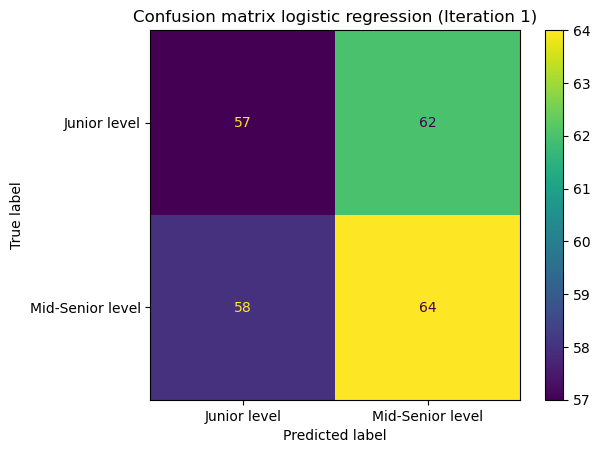

The accuracy score is 0.5021


In [22]:
logit_predictions = Log_gs_cv.best_estimator_.predict(X_test_svd)
logit_accuracy = accuracy_score(y_test, logit_predictions)

cm = confusion_matrix(y_test, logit_predictions, labels= Log_gs_cv.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=Log_gs_cv.classes_)
disp.plot()
plt.title('Confusion matrix logistic regression (Iteration 1)')
plt.show()
print("The accuracy score is {}".format(round(logit_accuracy,4)))

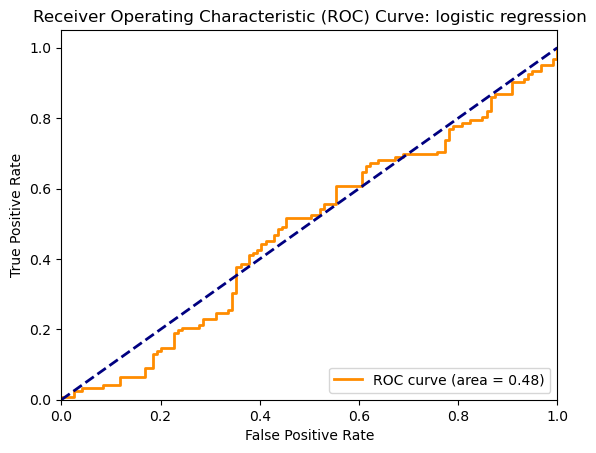

The AUC score is 0.4809


In [25]:
logit_predictions_proba = Log_gs_cv.best_estimator_.predict_proba(X_test_svd)
roc_plot(logit_predictions_proba[:, 1],'logistic regression')

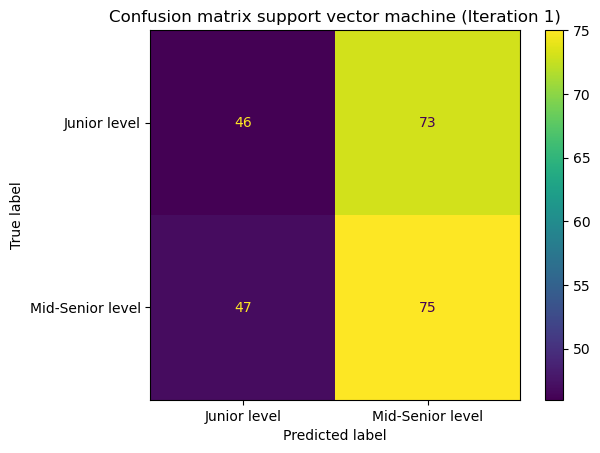

The accuracy score is 0.5021


In [26]:
svm_predictions = Svm_gs_cv.best_estimator_.predict(X_test_svd)
svm_accuracy = accuracy_score(y_test, svm_predictions)

cm = confusion_matrix(y_test, svm_predictions, labels= Svm_gs_cv.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=Svm_gs_cv.classes_)
disp.plot()
plt.title('Confusion matrix support vector machine (Iteration 1)')
plt.show()

print("The accuracy score is {}".format(round(svm_accuracy,4)))

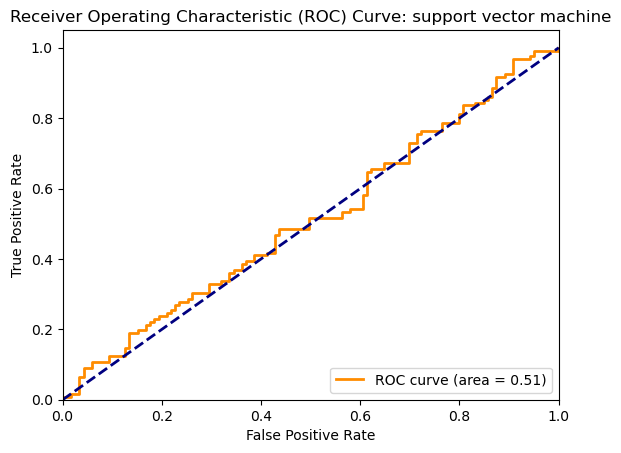

The AUC score is 0.5147


In [27]:
Svm_predictions_proba = Svm_gs_cv.best_estimator_.predict_proba(X_test_svd)
roc_plot(Svm_predictions_proba[:, 1],'support vector machine')

In [28]:
%%markdown
# Sources
https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc#:~:text=hypothetical%20perfect%20model.-,Area%20under%20the%20curve%20(AUC),positive%20higher%20than%20the%20negative.

# Sources
https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc#:~:text=hypothetical%20perfect%20model.-,Area%20under%20the%20curve%20(AUC),positive%20higher%20than%20the%20negative.
